<a href="https://colab.research.google.com/github/pankhurivanjani/Extended_plant_disease_detecttion/blob/WIP-pankhuri/plant_disease2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# dependencies
import cv2
import os
from pathlib import Path
from __future__ import division
from torchvision import models
from torchvision import transforms
from PIL import Image
import argparse
import torch
from torchvision import datasets, transforms, models 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import json
import matplotlib.pyplot as plt

In [3]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# Load the data and organizing it 
root_dir = 'drive/My Drive/'
data_dir = root_dir + 'plant-disease-dataset/testing'
nthreads = 4
batch_size = 32

In [5]:
##https://palikar.github.io/posts/pytorch_datasplit/
##https://dev.to/abiodunjames/building-an-image-classifier-using-pytorch-46dk
##https://github.com/MarkoArsenovic/DeepLearning_PlantDiseases/blob/master/Scripts/train.py
##https://github.com/viritaromero/Plant-diseases-classifier/blob/master/plant_diseased_classifier.py

In [6]:
### Load the mapping for category label to category name
with open(data_dir+ '/'+'categories.json', 'r') as f:
  category_name = json.load(f)

In [7]:
### Splitting the data; Reading the loaded Dataset
train_size, valid_size = 0.8, 0.2
transform = transforms.Compose([transforms.Resize(314), #prev 255
                                transforms.CenterCrop(299), #prev 224
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])
                               ])
dataset = datasets.ImageFolder(data_dir, transform=transform)


In [8]:
### Transforming and loading images
from torch.utils.data.sampler import SubsetRandomSampler

#dataset distribution
num_data = len(dataset)
indices = list(range(num_data))
np.random.shuffle(indices)
split = int(np.floor(train_size * num_data))

train_idx, valid_idx = indices[:split], indices[ split:]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape: (32, 3, 299, 299) Batch size: 32
label size: 0


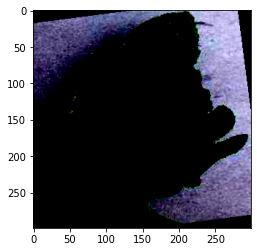

In [9]:
### Visualizing data
images, labels = next(iter(train_loader))
images = images.numpy()

print("Shape:", images.shape, "Batch size:", len(images))
plt.imshow(np.transpose(images[0], (1,2,0)))
print("label size:" , labels[4].numpy())

In [10]:
#Downloading and building the classifier

model = models.resnext101_32x8d(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [11]:
### Freeze parameters
for param in model.parameters():
  param.requires_grad = False

In [12]:
### Defining new classification layer (Feed-forward network as a classifier using ReLU activations)

classifier = nn.Sequential(nn.Linear(2048,1024),
                   nn.ReLU(),
                   nn.Dropout(0.3),
                   nn.Linear(1024,512),
                   nn.ReLU(),
                   nn.Dropout(0.3),
                   nn.Linear(512,2),
                   nn.LogSoftmax(dim=1))
model.fc = classifier

In [13]:
from torch import optim
### Loss of optimizers definition
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
##using adaptive learning rate
##from torch.optim import lr_scheduler
##exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [14]:
## Training and Validation
epochs = 29
train_losses, valid_losses = [], []
valid_loss_min = np.Inf

for e in range(epochs):
  running_loss = 0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    logps = model.forward(images)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  else: ##if in valid_loader
    valid_loss = 0
    accuracy = 0
    with torch.no_grad():
      model.eval()
      for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        log_ps = model(images)
        valid_loss += criterion(log_ps, labels)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()
    train_losses.append(running_loss/len(train_loader))
    valid_losses.append(valid_loss/len(valid_loader))
    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.3f}.. ".format(train_losses[-1]),
          "Validation Loss: {:.3f}.. ".format(valid_losses[-1]),
          "Validation Accuracy: {:.3f}".format(accuracy/len(valid_loader)))
    if valid_losses[-1] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_losses[-1]))
        torch.save(model.state_dict(), 'model_incept.pt')
        valid_loss_min = valid_losses[-1]


Epoch: 1/29..  Training Loss: 0.108..  Validation Loss: 0.002..  Validation Accuracy: 1.000
Validation loss decreased (inf --> 0.001861).  Saving model ...
Epoch: 2/29..  Training Loss: 0.100..  Validation Loss: 0.052..  Validation Accuracy: 0.986
Epoch: 3/29..  Training Loss: 0.026..  Validation Loss: 0.003..  Validation Accuracy: 1.000
Epoch: 4/29..  Training Loss: 0.018..  Validation Loss: 0.000..  Validation Accuracy: 1.000
Validation loss decreased (0.001861 --> 0.000382).  Saving model ...
Epoch: 5/29..  Training Loss: 0.009..  Validation Loss: 0.000..  Validation Accuracy: 1.000
Validation loss decreased (0.000382 --> 0.000178).  Saving model ...
Epoch: 6/29..  Training Loss: 0.015..  Validation Loss: 0.001..  Validation Accuracy: 1.000
Epoch: 7/29..  Training Loss: 0.028..  Validation Loss: 0.015..  Validation Accuracy: 0.995
Epoch: 8/29..  Training Loss: 0.012..  Validation Loss: 0.008..  Validation Accuracy: 0.995
Epoch: 9/29..  Training Loss: 0.010..  Validation Loss: 0.000.

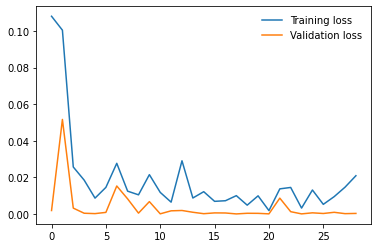

In [15]:
### Training and validation loss graph
plt.plot(train_losses, label = 'Training loss')
plt.plot(valid_losses, label = 'Validation loss')
plt.legend(frameon = False)

In [16]:
### Load the model state with lowest validation¶
model.load_state_dict(torch.load('model_incept.pt'))


<All keys matched successfully>

In [30]:
test_dir = data_dir + '/test'

In [48]:
testset = datasets.ImageFolder(test_dir, transform=transform)
num_test = len(testset)
indices = list(range(num_test))
x = int(np.floor(num_test))

test_idx = indices[:x]
test_sampler = SubsetRandomSampler(test_idx)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, sampler=test_sampler)


In [68]:
print(len(valid_loader))
print(len(train_loader))
print(num_test)
print(num_data)
print(len(test_loader))
print(len(valid_sampler))

24
94
17
3748
17
750


In [66]:
### Test the trained network
img, labs = next(iter(test_loader))
cls_len = len(test_loader)
test_loss = 0.0
accuracy = 0
model.eval()

for data, target in test_loader:
    data, target = data.cuda(), target.cuda()
    logs_ps = model(data)
    test_loss += criterion(logs_ps, target)
    ps = torch.exp(logs_ps)
    top_p, top_class = ps.topk(1, dim=1)
    equals = top_class == target.view(*top_class.shape)
    accuracy += torch.mean(equals.type(torch.FloatTensor))
print("Test loss: {:.3f}.. \t Test Accuracy: {:.3f}".format(test_loss/len(test_loader), accuracy/len(test_loader)))



Test loss: 1.399.. 	 Test Accuracy: 0.765
